# Data Analyst Take-Home Test: Payment Industry Case Study (DuckDB Version)
This notebook provides an analysis of payment transaction data, merchant details, and chargeback records using **DuckDB** for SQL-based querying.

## **Objectives:**
- **Understand trends in transaction volume and revenue**.
- **Identify top-performing merchants**.
- **Detect potential fraudulent activities**.
- **Assess the impact of failed transactions on revenue**.
- **Recommend strategies to improve transaction success rates**.

## **Dataset Information:**
- **transactions.csv**: Contains transaction records.
- **merchants.csv**: Contains merchant details.
- **chargebacks.csv**: Contains chargeback data (disputed transactions).

In [4]:

import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")

# Load the datasets
transactions_path = "transactions.csv"
merchants_path = "merchants.csv"
chargebacks_path = "chargebacks.csv"

# Read data into Pandas DataFrames
transactions = pd.read_csv(transactions_path)
merchants = pd.read_csv(merchants_path)
chargebacks = pd.read_csv(chargebacks_path)

# Convert date columns only if necessary
if transactions['transaction_date'].dtype != 'datetime64[ns]':
    transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

if chargebacks['chargeback_date'].dtype != 'datetime64[ns]':
    chargebacks['chargeback_date'] = pd.to_datetime(chargebacks['chargeback_date'])

# Create an in-memory DuckDB database
con = duckdb.connect(database=':memory:')

# Load data into DuckDB
con.register('transactions', transactions)
con.register('merchants', merchants)
con.register('chargebacks', chargebacks)


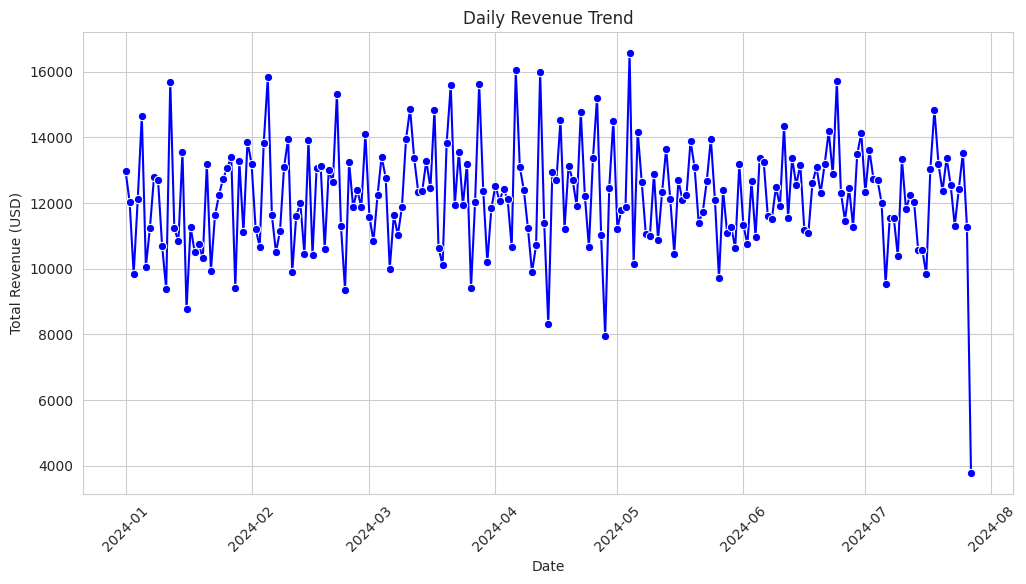

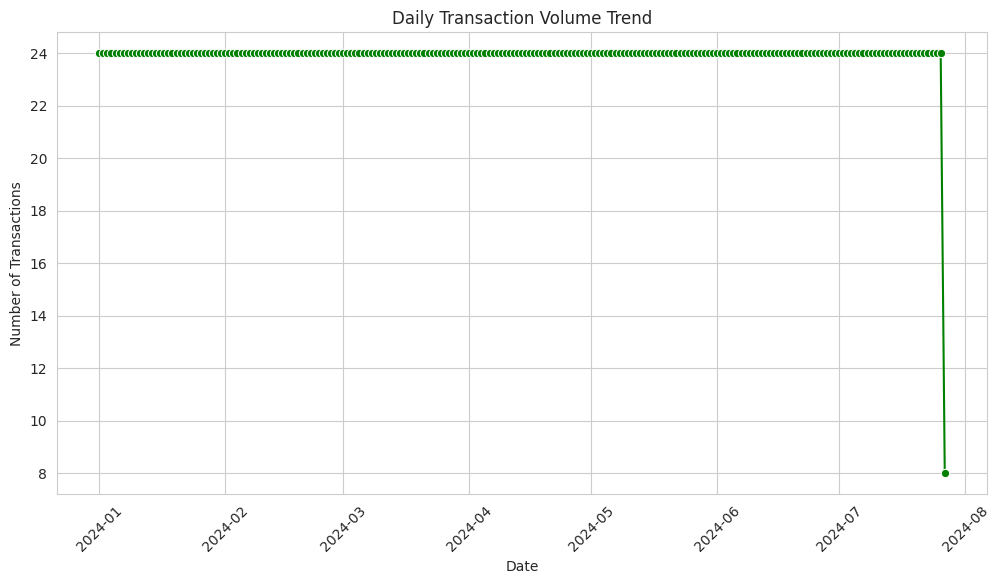

In [5]:

# Query revenue and transaction trends using DuckDB
query = '''
SELECT 
    DATE_TRUNC('day', transaction_date) AS transaction_day, 
    COUNT(transaction_id) AS transaction_count, 
    SUM(transaction_amount) AS total_revenue
FROM transactions
GROUP BY transaction_day
ORDER BY transaction_day
'''
daily_trends = con.execute(query).fetchdf()

# Plot revenue trend
plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_trends['transaction_day'], y=daily_trends['total_revenue'], marker='o', color='blue')
plt.title("Daily Revenue Trend")
plt.xlabel("Date")
plt.ylabel("Total Revenue (USD)")
plt.xticks(rotation=45)
plt.show()

# Plot transaction volume trend
plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_trends['transaction_day'], y=daily_trends['transaction_count'], marker='o', color='green')
plt.title("Daily Transaction Volume Trend")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.show()


/tmp/ipykernel_8571/2652618475.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_merchants_df["total_revenue"], y=top_merchants_df["merchant_name"], palette="Blues_r")


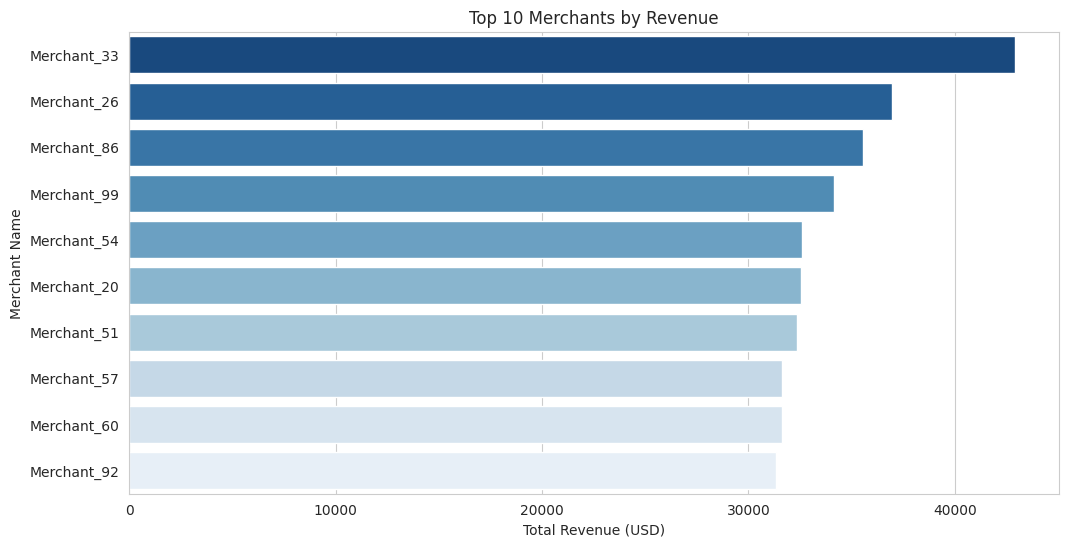

In [6]:

# Query top merchants by revenue
query = '''
SELECT 
    t.merchant_id, 
    m.merchant_name, 
    SUM(t.transaction_amount) AS total_revenue
FROM transactions t
JOIN merchants m ON t.merchant_id = m.merchant_id
GROUP BY t.merchant_id, m.merchant_name
ORDER BY total_revenue DESC
LIMIT 10
'''
top_merchants_df = con.execute(query).fetchdf()

# Plot top merchants
plt.figure(figsize=(12, 6))
sns.barplot(x=top_merchants_df["total_revenue"], y=top_merchants_df["merchant_name"], palette="Blues_r")
plt.title("Top 10 Merchants by Revenue")
plt.xlabel("Total Revenue (USD)")
plt.ylabel("Merchant Name")
plt.show()

/tmp/ipykernel_8571/2701886185.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_chargeback_merchants["chargeback_count"], y=top_chargeback_merchants["merchant_name"], palette="Reds_r")


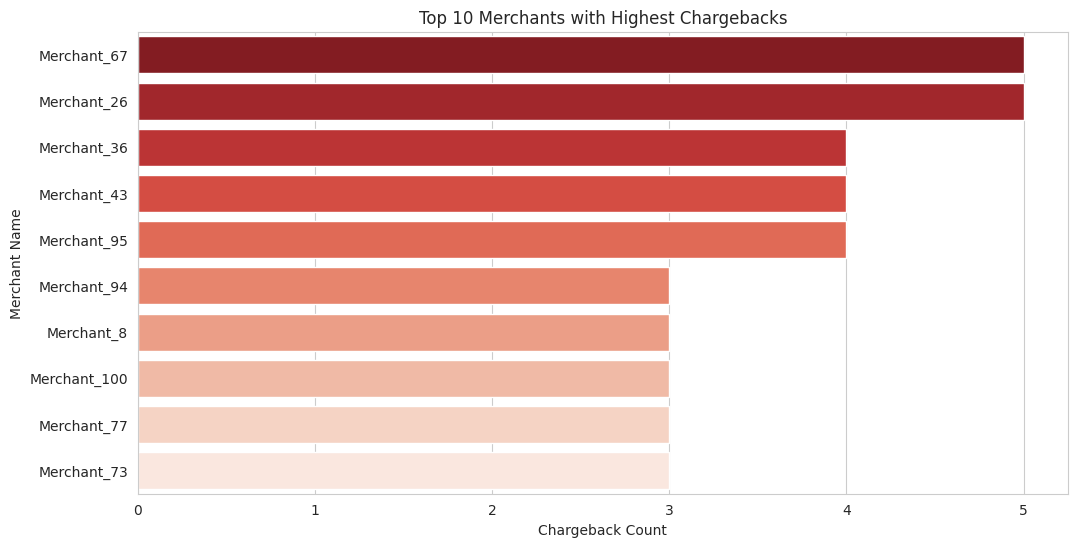

In [8]:

# Query chargeback rates per merchant
query = '''
SELECT 
    t.merchant_id, 
    m.merchant_name,
    COUNT(c.chargeback_id) AS chargeback_count,
    SUM(c.chargeback_amount) AS total_chargeback_amount
FROM chargebacks c
JOIN transactions t ON c.transaction_id = t.transaction_id
JOIN merchants m ON t.merchant_id = m.merchant_id
GROUP BY t.merchant_id, m.merchant_name
ORDER BY chargeback_count DESC
LIMIT 10
'''
top_chargeback_merchants = con.execute(query).fetchdf()

# Visualize chargeback rates
plt.figure(figsize=(12, 6))
sns.barplot(x=top_chargeback_merchants["chargeback_count"], y=top_chargeback_merchants["merchant_name"], palette="Reds_r")
plt.title("Top 10 Merchants with Highest Chargebacks")
plt.xlabel("Chargeback Count")
plt.ylabel("Merchant Name")
plt.show()


In [16]:
# Identify potential fraud (high transaction anomalies)
query = '''
SELECT 
    transaction_id, 
    merchant_id, 
    transaction_date, 
    transaction_amount
FROM transactions
WHERE transaction_amount > (SELECT AVG(transaction_amount) + 3 * STDDEV(transaction_amount) FROM transactions)
ORDER BY transaction_amount DESC;
'''
high_transaction_anomalies = con.execute(query).fetchdf()
print(high_transaction_anomalies)

Empty DataFrame
Columns: [transaction_id, merchant_id, transaction_date, transaction_amount]
Index: []


/tmp/ipykernel_8571/848239174.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=payment_methods_df["payment_method"], y=payment_methods_df["transaction_count"], palette="Greens_r")


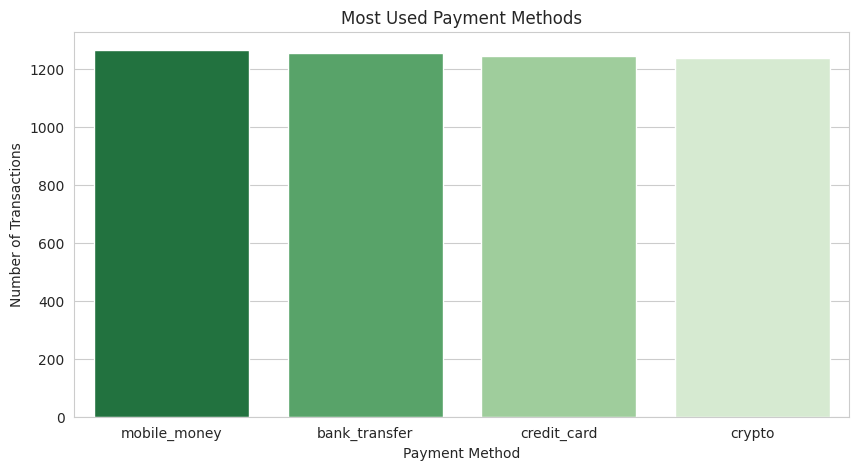

In [17]:
query = '''
SELECT
    payment_method,
    COUNT(transaction_id) AS transaction_count,
    SUM(transaction_amount) AS total_revenue,
    SUM(CASE WHEN status = 'successful' THEN 1 ELSE 0 END) * 100.0 / COUNT(transaction_id) AS success_rate
FROM transactions
GROUP BY payment_method
ORDER BY transaction_count DESC
'''
payment_methods_df = con.execute(query).fetchdf()

plt.figure(figsize=(10, 5))
sns.barplot(x=payment_methods_df["payment_method"], y=payment_methods_df["transaction_count"], palette="Greens_r")
plt.title("Most Used Payment Methods")
plt.xlabel("Payment Method")
plt.ylabel("Number of Transactions")
plt.show()

/tmp/ipykernel_8571/948698441.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries_df["total_revenue"], y=top_countries_df["country"], palette="Blues_r")


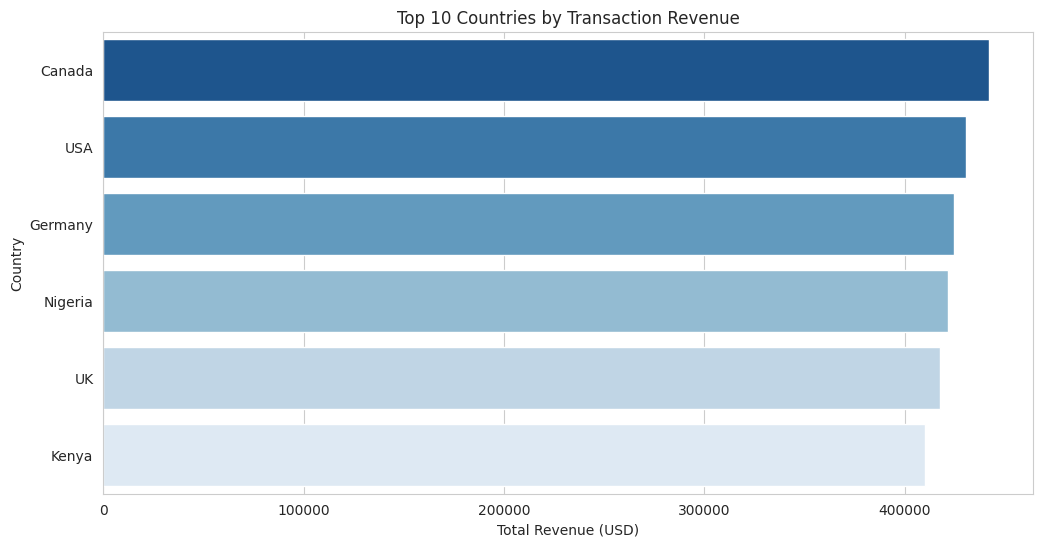

In [18]:
query = '''
SELECT
    country,
    SUM(transaction_amount) AS total_revenue,
    COUNT(transaction_id) AS transaction_count
FROM transactions
GROUP BY country
ORDER BY total_revenue DESC
LIMIT 10
'''
top_countries_df = con.execute(query).fetchdf()

plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries_df["total_revenue"], y=top_countries_df["country"], palette="Blues_r")
plt.title("Top 10 Countries by Transaction Revenue")
plt.xlabel("Total Revenue (USD)")
plt.ylabel("Country")
plt.show()

/tmp/ipykernel_8571/606343117.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_customers_df["total_spent"], y=top_customers_df["customer_id"], palette="Purples_r")


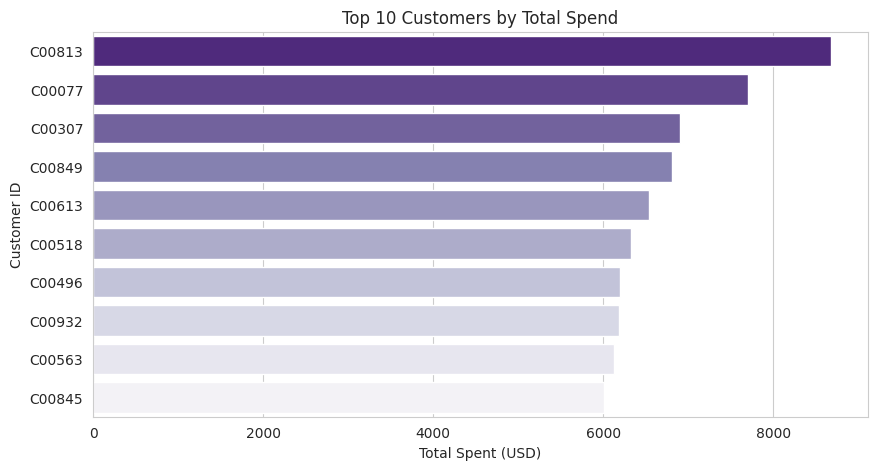

In [19]:
query = '''
SELECT
    customer_id,
    COUNT(transaction_id) AS transaction_count,
    SUM(transaction_amount) AS total_spent
FROM transactions
GROUP BY customer_id
ORDER BY total_spent DESC
LIMIT 10
'''
top_customers_df = con.execute(query).fetchdf()

plt.figure(figsize=(10, 5))
sns.barplot(x=top_customers_df["total_spent"], y=top_customers_df["customer_id"], palette="Purples_r")
plt.title("Top 10 Customers by Total Spend")
plt.xlabel("Total Spent (USD)")
plt.ylabel("Customer ID")
plt.show()

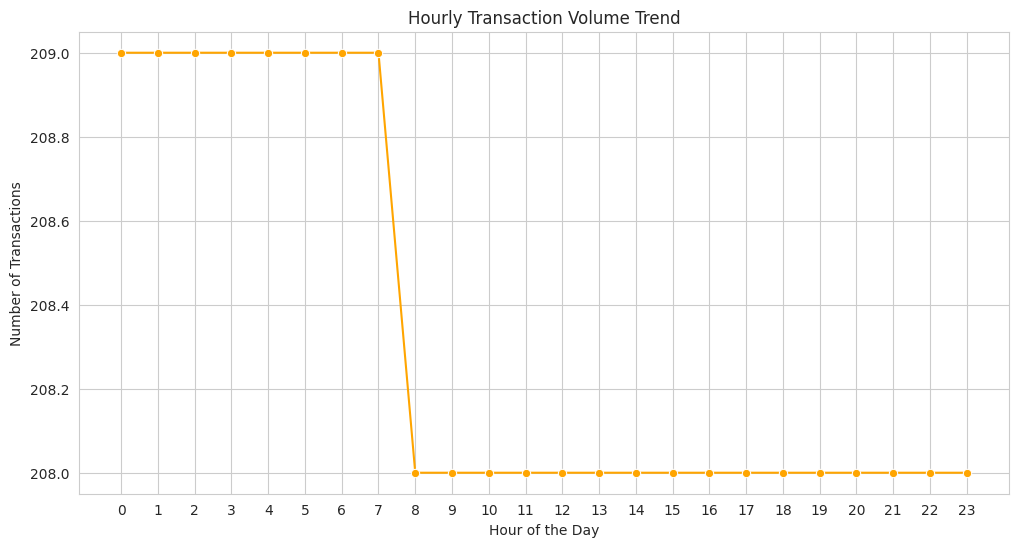

In [20]:
query = '''
SELECT
    EXTRACT(HOUR FROM transaction_date) AS transaction_hour,
    COUNT(transaction_id) AS transaction_count
FROM transactions
GROUP BY transaction_hour
ORDER BY transaction_hour
'''
hourly_trends_df = con.execute(query).fetchdf()

plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_trends_df["transaction_hour"], y=hourly_trends_df["transaction_count"], marker='o', color='orange')
plt.title("Hourly Transaction Volume Trend")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Transactions")
plt.xticks(range(0, 24))
plt.show()

In [22]:
# Query: Transaction Failures
query = '''
SELECT COUNT(*) AS failed_transactions
FROM transactions
WHERE status = 'Failed';
'''
df_failures = con.execute(query).fetchdf()
print("Identified Failed Transactions:", df_failures.iloc[0, 0])

Identified Failed Transactions: 0


Total Chargebacks: 126
                  reason  chargeback_count
0                  fraud                39
1  duplicate transaction                38
2           unauthorized                26
3   product not received                23


/tmp/ipykernel_8571/237022612.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_chargebacks["reason"], y=df_chargebacks["chargeback_count"], palette="Reds_r")


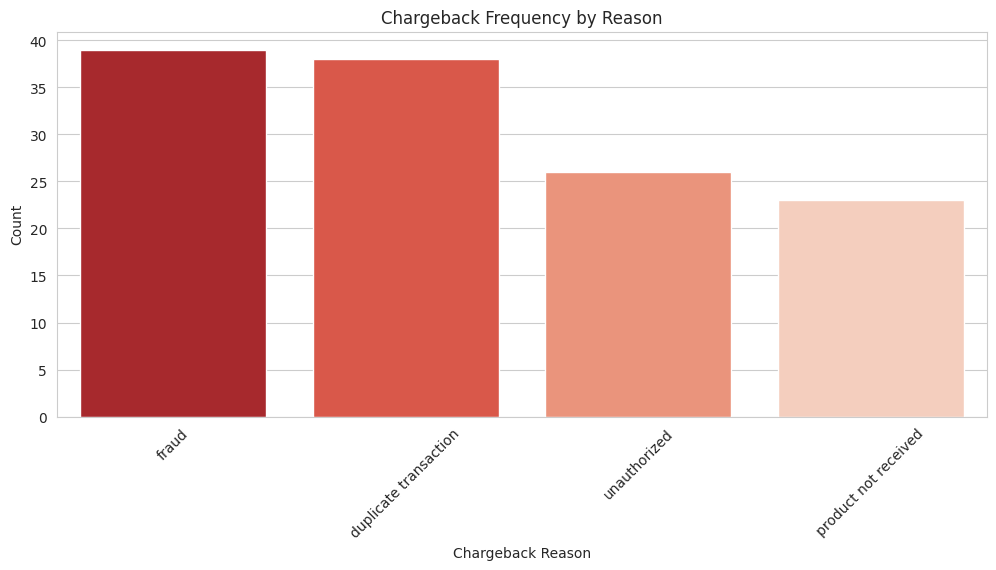

In [23]:
# Query: Chargeback Reasons
query = '''
SELECT reason, COUNT(*) AS chargeback_count
FROM chargebacks
GROUP BY reason
ORDER BY chargeback_count DESC;
'''
df_chargebacks = con.execute(query).fetchdf()
print("Total Chargebacks:", df_chargebacks["chargeback_count"].sum())
print(df_chargebacks)

# Plot Chargeback Reasons Distribution
plt.figure(figsize=(12, 5))
sns.barplot(x=df_chargebacks["reason"], y=df_chargebacks["chargeback_count"], palette="Reds_r")
plt.title("Chargeback Frequency by Reason")
plt.xlabel("Chargeback Reason")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [30]:
# Query: Top 10 Merchants by Chargeback Ratio
query = '''
SELECT 
    c.merchant_id, 
    m.merchant_name, 
    COUNT(c.chargeback_id) AS total_chargebacks,
    COUNT(t.transaction_id) AS total_transactions,
    ROUND((COUNT(c.chargeback_id) * 100.0 / COUNT(t.transaction_id)), 2) AS chargeback_ratio
FROM transactions t
JOIN chargebacks c ON t.transaction_id = c.transaction_id
JOIN merchants m ON c.merchant_id = m.merchant_id
GROUP BY c.merchant_id, m.merchant_name
HAVING COUNT(c.chargeback_id) > 0
ORDER BY chargeback_ratio DESC
LIMIT 10;
'''
df_chargeback_ratio = con.execute(query).fetchdf()
print("Chargeback Ratio:", df_chargeback_ratio)

Chargeback Ratio:   merchant_id merchant_name  total_chargebacks  total_transactions  \
0       M0020   Merchant_20                  1                   1   
1       M0094   Merchant_94                  3                   3   
2       M0067   Merchant_67                  5                   5   
3       M0059   Merchant_59                  2                   2   
4       M0033   Merchant_33                  3                   3   
5       M0099   Merchant_99                  1                   1   
6       M0001    Merchant_1                  2                   2   
7       M0093   Merchant_93                  3                   3   
8       M0043   Merchant_43                  4                   4   
9       M0052   Merchant_52                  2                   2   

   chargeback_ratio  
0             100.0  
1             100.0  
2             100.0  
3             100.0  
4             100.0  
5             100.0  
6             100.0  
7             100.0  
8            

In [9]:
# Query total revenue lost due to failed transactions
query = '''
SELECT 
    SUM(transaction_amount) AS failed_revenue_loss
FROM transactions
WHERE status = 'failed'
'''
failed_revenue_loss = con.execute(query).fetchdf().iloc[0, 0]

print(f"Total Revenue Lost Due to Failed Transactions: ${failed_revenue_loss:,.2f}")


Total Revenue Lost Due to Failed Transactions: $271,017.18


## **Business Recommendations**
### **1. Improve Transaction Success Rates**
- Identify merchants with high failure rates and address issues.
- Improve payment gateway reliability and error handling.

### **2. Reduce Fraud & Chargebacks**
- Monitor merchants with high chargeback rates.
- Enforce two-factor authentication for high-value transactions.
- The merchants with charge back require risk management intervention
- Implement real-time fraud scoring for high-risk merchants
- Strengthen authentication processes for transactions

### **3. Expand Profitable Segments**
- Focus on high-revenue merchants and encourage repeat business.
- Provide incentives for top-performing categories.

### **4. Optimize Payment Methods**
- Identify underperforming payment methods and optimize their usage.
- Encourage customers to use more successful payment channels.